In [1]:
%load_ext autoreload
%autoreload 2
CMUdict_ARPAbet = {
    "" : " ",
    "[SIL]": "-", "NG": "G", "F" : "f", "M" : "m", "AE": "@",
    "R"    : "r", "UW": "u", "N" : "n", "IY": "i", "AW": "W",
    "V"    : "v", "UH": "U", "OW": "o", "AA": "a", "ER": "R",
    "HH"   : "h", "Z" : "z", "K" : "k", "CH": "C", "W" : "w",
    "EY"   : "e", "ZH": "Z", "T" : "t", "EH": "E", "Y" : "y",
    "AH"   : "A", "B" : "b", "P" : "p", "TH": "T", "DH": "D",
    "AO"   : "c", "G" : "g", "L" : "l", "JH": "j", "OY": "O",
    "SH"   : "S", "D" : "d", "AY": "Y", "S" : "s", "IH": "I",
    "[SOS]": "[SOS]", "[EOS]": "[EOS]"
}

CMUdict = list(CMUdict_ARPAbet.keys())
ARPAbet = list(CMUdict_ARPAbet.values())

PHONEMES = CMUdict[:-2]
LABELS = ARPAbet[:-2]

## The Data

In [3]:
import dataset
from dataset import AudioDataset

# probably want to collect some RAM before we go.

#train_data = AudioDataset('train-clean-100', data_dir="../../data/ARPAbet_kaggle")
train_data = AudioDataset('dev-clean', data_dir="../../data/ARPAbet_kaggle")


create dataset from data  ../../data/ARPAbet_kaggle/dev-clean
	total mfcc cnt:  2703
	total transcript cnt:  2703


one observation to make is that each trancript
starts with [SIL] and ends with [SIL]. There are moments of silence at the beginning and end of each recording, which should be mapped to this token.

The \<sos\> and \<eos\> tokens have been removed in dataset.

In [30]:
mfcc,  transcript = train_data[0]
print(mfcc.shape, mfcc.dtype)
print(transcript)
string = [train_data.idx_to_str(x) for x in transcript]
print(" ".join(string))

mfcc,  transcript = train_data[3]
print(mfcc.shape, mfcc.dtype)
print(transcript)
string = [train_data.idx_to_str(x) for x in transcript]
print(" ".join(string))


(830, 28) float32
[ 1 26  8 37 30 26 28 12  6 39 40 33  9 29 40  2 17  6 26  3 26 33 37 26
 28 30 24  6  3 24 30 15 17  1 26  8 37 33 12 18 23  4 40 17 15 26 27 26
 33  1  5 17 13  8 33  9 26 33 40 23 26 33 27 15 37 18  5  8 33 12 18 20
 24  8 40 23 40 17 26  8 16  5 28  9  1]
[SIL] AH N D DH AH P UH R S IH L IY TH IH NG Z R AH F AH L D AH P DH EH R F EH DH ER Z [SIL] AH N D L UH K T M IH Z ER AH B AH L [SIL] AE Z OW N L IY AH L IH T AH L B ER D K AE N L UH K W EH N IH T IH Z AH N HH AE P IY [SIL]
(878, 28) float32
[ 1 30 40 39 20 14 17 30 26 13 33 37 40 39 23  5 27 33 40 36  4 26  8 23
 26 11 15 39 26 39  1 40 23 39 28  6 26 28 31  6 36 26  8 17 14 32  4 24
  8 23 26 37 27 38 39 26 18 39 24 39  1 26  8 37 40  4 28  6  7 11 37  3
  6 26  4 26  6 24 19 40 37 27  7 29 40  8 23  7 26 29  9 26 23 15  1]
[SIL] DH IH S W AA Z DH AH OW L D IH S T AE B L IH SH M AH N T AH V ER S AH S [SIL] IH T S P R AH P AO R SH AH N Z AA G M EH N T AH D B AY S AH K S EH S [SIL] AH N D IH M P R UW V D F R AH 

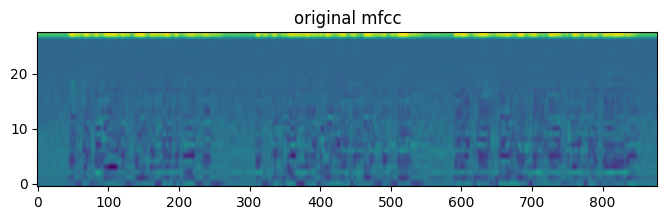

In [31]:
import matplotlib_inline
import matplotlib.pyplot as plt
def plot(x, title):
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.set_title(title)
    ax.imshow(x, origin="lower", aspect="auto")
    
plot(mfcc.transpose(1, 0), "original mfcc")


torch.Size([1, 27, 878])


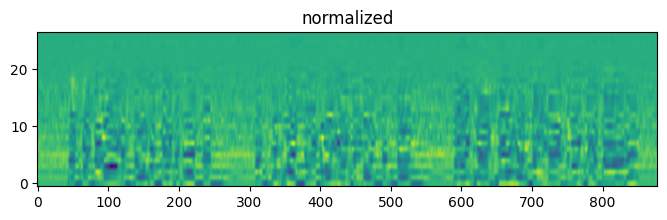

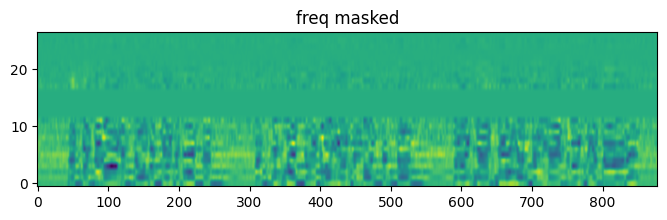

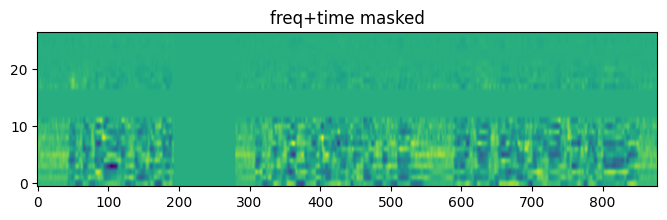

In [52]:
import torch
import torchaudio.transforms as transforms
# last dimension has higher values than all other dimensions.. maybe ignore it?
normalized_mfcc = mfcc.transpose(1, 0)[:27, :]
normalized_mfcc = normalized_mfcc - normalized_mfcc.mean(axis=-1, keepdims=True)
normalized_mfcc = normalized_mfcc.transpose(0, 1)
plot(normalized_mfcc, "normalized")

normalized_mfcc = torch.as_tensor(normalized_mfcc).unsqueeze(0)
print(normalized_mfcc.shape)

fmask = transforms.FrequencyMasking(freq_mask_param=6)
masked_mfcc = fmask(normalized_mfcc)
plot(masked_mfcc[0], "freq masked")

tmask = transforms.TimeMasking(time_mask_param=100)
masked_mfcc = tmask(masked_mfcc)
plot(masked_mfcc[0], "freq+time masked")


In [37]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader =  DataLoader(
            train_data,
            batch_size=batch_size,
            drop_last=True,
            shuffle=True,
            collate_fn=train_data.collate_fn
)


print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))

# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break


Train dataset samples = 28539, batches = 445
torch.Size([64, 1611, 28]) torch.Size([64, 226]) torch.Size([64]) torch.Size([64])


## The Model

In [8]:
from model import ASRModel
from defines import PHONEMES

model = ASRModel(
    input_size = 28, 
    embed_size= 64,
    output_size = len(PHONEMES)
)
for data in train_loader:
    x, y, lx, ly = data
    decoder_out, encoder_lens = model.forward(x, lx)
    break

torch.Size([64, 1671, 28]) torch.Size([64, 281]) torch.Size([64]) torch.Size([64])


In [20]:
print(len(LABELS))
print(LABELS)

for i in range(10):
    mfcc,  transcript = val_data[i]
    sent = [val_data.int_to_str(s) for s in transcript]
    print(''.join(sent))

print(sorted(LABELS))

41
[' ', '-', 'G', 'f', 'm', '@', 'r', 'u', 'n', 'i', 'W', 'v', 'U', 'o', 'a', 'R', 'h', 'z', 'k', 'C', 'w', 'e', 'Z', 't', 'E', 'y', 'A', 'b', 'p', 'T', 'D', 'c', 'g', 'l', 'j', 'O', 'S', 'd', 'Y', 's', 'I']
[SOS]AND THE POOR SILLY THINGS RUFFLED UP THEIR FEATHERS AND LOOKED MISERABLE AS ONLY A LITTLE BIRD CAN LOOK WHEN IT IS UNHAPPY[EOS]
[SOS]HE THOUGHT IT WAS A LAST BURST OF ENERGY HE KNEW HOW CLOSE THEY BOTH WERE TO EXHAUSTION[EOS]
[SOS]WE WERE INURED TO PRIVATIONS AND HARDSHIPS HAD BEEN UPON EVERY MARCH IN EVERY BATTLE IN EVERY SKIRMISH IN EVERY ADVANCE IN EVERY RETREAT IN EVERY VICTORY IN EVERY DEFEAT[EOS]
[SOS]THIS WAS THE OLD ESTABLISHMENT OF URSUS ITS PROPORTIONS AUGMENTED BY SUCCESS AND IMPROVED FROM A WRETCHED BOOTH INTO A THEATRE[EOS]
[SOS]LETTY FINDING HERSELF NOT QUITE EQUAL TO THE EMERGENCY CAME IN HER TURN TO CALL MARY SHE WENT AS QUIETLY AS IF SHE WERE LEAVING A TIRESOME VISITOR[EOS]
[SOS]BUT EARNEST AS THE FATHER WAS IN WATCHING THE YET LIVING HE HAD EYES AND EARS FOR